# Large-scale networks for the self-optimization model enabled by on-the-fly computation of weights

Created by Natalya Weber

This jupyter notebook accompanies the paper: [Large-scale networks for the self-optimization model enabled by on-the-fly computation of weights](https://arxiv.org/abs/2211.01698)

## Import libraries

In [34]:
using PyCall            # Used func: pyimport

axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

using PyPlot
using BSON              # Used for export
using LaTeXStrings      # Used for nice plot titles
using Random            # Used func: rand
using LinearAlgebra     # Used func: Symmetric, diagind
using StatsBase         # Used func: fit
using SparseArrays      # Used func: sprand
using BenchmarkTools    # Used func: @btime

include("par_init.jl");
include("func.jl");

## Initialize

In [35]:
mydict = Dict{String,Any}(
    "N"             => 100      , # network size
    "ts_multip"     => 10       , # sets the size of steps
    "resets"        => 1000     , # number of resets
    "alpha"         => 1.00e-6  , # learning rate
    "d"             => 0.1      , # for sparse w: density of non-zero values
    "k"             => 5        , # for modular w: size of module
    "p"             => 0.1      , # for modular w: intermodule connections set to {-p,p} with equal probability
    "w_seed"        => 123456   , # seed for specific w_orig
);

prt = Param(mydict);

## Run the simulation 

In [36]:
speed = true       # speed up by not explicitly adding w=w+dw
modular = true
name() = if modular "modular" else "sparse" end

N = prt.N                     # pointer
ts = prt.steps                # pointer
alpha = prt.alpha             # pointer

# sim_seed = rand(1:2^16)
sim_seed = 4724

eta = round(Int,1/alpha)
var = Variables(prt, N, ts)


println("\nStarting simulation for ", name(), " matrix, N=", N, ", α=", alpha, " , speed=", string(speed))
var.sim_seed = sim_seed

Random.seed!(prt.w_seed) # make sure you start with same weight matrix
if modular
    var.w_or = w_modular(N, prt, var)
else
    var.w_or = w_sparse(N, prt, var)
end

eta = round(Int, 1 / alpha)

var.w = round.(Int, var.w_or .* eta)

# simulate without learning (Initial random disrtibution)
println("\nSimulation without learning...")
num = 1
@time simulate(N, eta, ts, prt, var, speed, false, num) # without learning
# simulate with learning
println("\nSimulation with learning...")
num += 1
@time simulate(N, eta, ts, prt, var, speed, true, num) # with learning
# simulate without learning (for testing)
println("\nSimulation without learning...")
num += 1
@time simulate(N, eta, ts, prt, var, speed, false, num) # without learning


Starting simulation for modular matrix, N=100, α=1.0e-6 , speed=true

Simulation without learning...
  1.939441 seconds (11.96 M allocations: 1.845 GiB, 10.86% gc time)

Simulation with learning...
 18.911735 seconds (219.25 M allocations: 6.163 GiB, 5.10% gc time)

Simulation without learning...
  1.690335 seconds (11.96 M allocations: 1.845 GiB, 3.79% gc time)


## Visualization

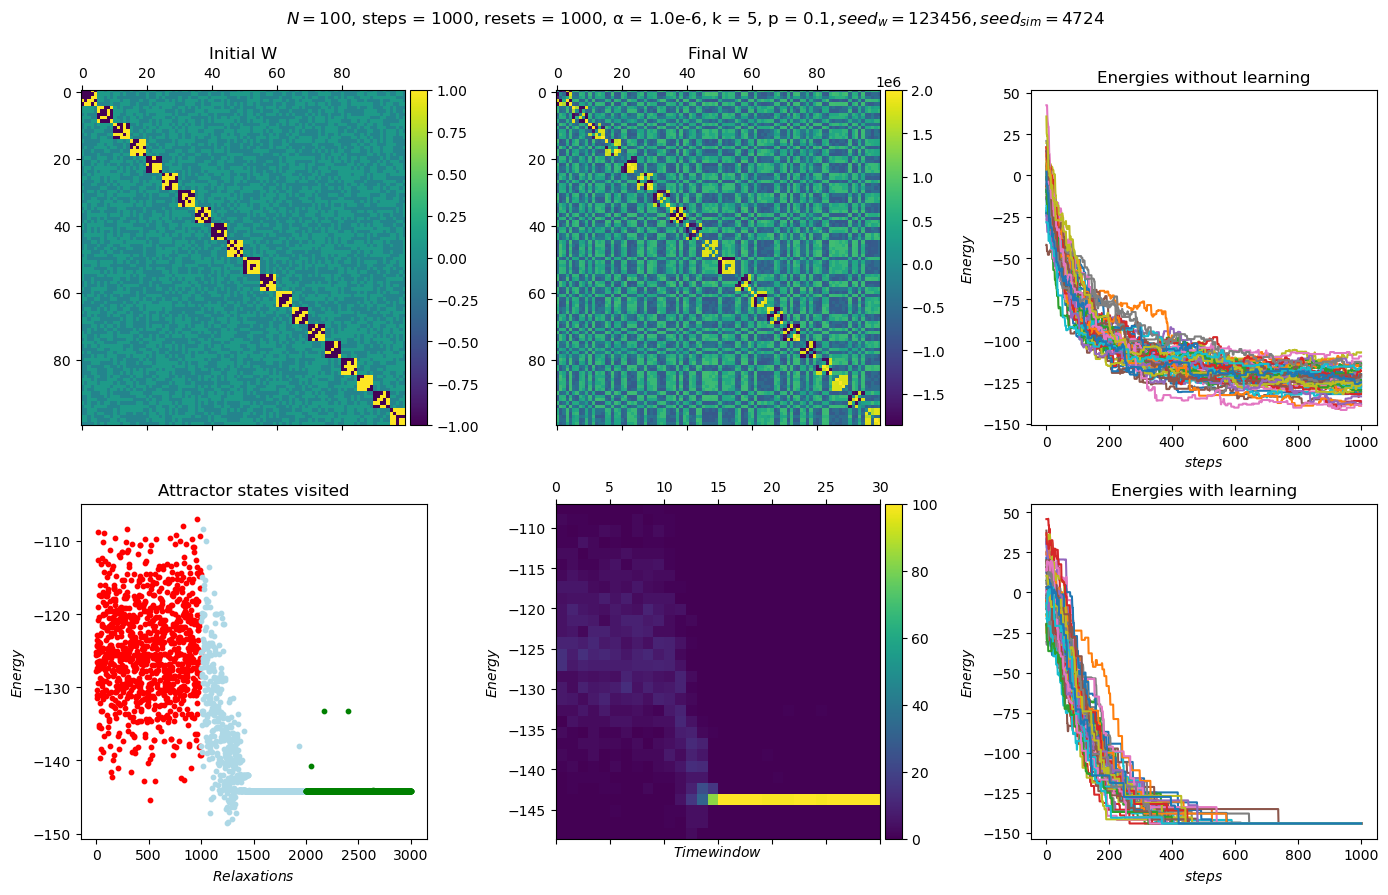

In [37]:
fig_text = "N_" * string(N) * "_eta_" * string(eta)
figure(fig_text, figsize = (14, 9))
plot_all_6(prt, var, num);
subplots_adjust(top = 0.9)

if modular
    title_text =
        L"N = " * string(N) *", steps = " *string(ts) *", resets = " *string(prt.resets) *
        ", α = " *string(alpha) *", k = " *string(prt.k) *", p = " *string(prt.p) *
        L"$, seed_{w} = $" *string(prt.w_seed) *L"$, seed_{sim} = $" *string(var.sim_seed)
else
    title_text =
        L"N = " *string(N) *", steps = " *string(ts) *", resets = " *string(prt.resets) *
        ", α = " *string(alpha) *", d = " *string(prt.d) *
        L"$, seed_{w} = $" *string(prt.w_seed) *L"$, seed_{sim} = $" *string(var.sim_seed)
end
suptitle(title_text, y = 0.99);

path_out = "./output/output_julia/"
if modular
    folder_name = "Modular/" * "N_" * string(N) * "/k_" * string(prt.k) * "/"
else
    folder_name = "Sparse/" * "N_" * string(N) * "/d_" * string(prt.d) * "/"
end
if isdir(path_out * folder_name) else mkpath(path_out * folder_name) end


output_files = true 
output_bson = false

if output_files
    # Save the figures
    filename = "N_" *string(N) *"_eta_" *string(eta) *"_s_" *string(var.sim_seed)
    fig_name = filename * ".png"
    savefig(path_out * folder_name * fig_name)
#     fig_name = filename * ".svg"
#     savefig(path_out * folder_name * fig_name)

    if output_bson # Save the data
        bson_name = filename * "_main.bson"
        type_name = name()
        w_or = var.w_or
        BSON.@save joinpath(path_out, folder_name, bson_name) params = N type_name alpha ts speed prt w_or
    end
end